In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize

%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["font.size"] = 12

# basic phosphorylation model

Take $X_i$ to be the $i^{th}$ signaling molecule in a phosphorylation cascade. Define $\tilde{X_i}$ and $X_i$ as the concentration of unphosphorylated receptor and phosphorylated receptor, respectively. 

<div>
<img src="images/phospho_cascade.png" width="500"/>
</div>

The ODE model for this system is:

$$ \frac{dX_i}{dt} = \tilde{\alpha_i}X_{i-1}\tilde{X_i} - \beta_i X_i $$
$$ \frac{d\tilde{X_i}}{dt}  = \beta_i X_i - \tilde{\alpha_i}X_{i-1}\tilde{X_i}  $$

The total concentration of $i^{th}$ signaling molecules, $X_{iT}$ in this system is defined by the following equation:

$$ X_{iT} = \tilde{X_i} + X_i $$

Note that in this system, $ dX_{iT}/dt = 0 $, meaning $X_{iT}$ is some constant which we consider a parameter of the system. We can take advantage of this to reduce the number of species we must explicitly model. We can rewrite $dX_i/dt$ such that it doesn't depend on $\tilde{X_i}$, eliminating the need to explicitly model $\tilde{X_i}$. The resulting equation is:

$$ \frac{dX_i}{dt} = \alpha_i X_{i-1} \left[ 1 - \frac{X_i}{X_{iT}} \right] - \beta_i X_i $$ 

Where $\alpha_i = \tilde{\alpha_i}X_{iT}$. Thus, we eliminate the need to explicitly model $\tilde{X_i}$ during numerical integration.

However, when we model the effects of inhibitors, we must explicitly model $\tilde{X_i}$ for the signaling protein that is being inhibited.

The inhibtors we will model are allosteric. Define $I$ as the concentration of an inhibitor that inhibits the $i^{th}$ signaling molecule by binding (reversibly) to its unphosphorylated form, $\tilde{X_i}$.

<div>
<img src="images/phospho_inhibited.png" width="500"/>
</div>

Therefore, for the signaling molecules which are targeted by an inhibitor, we will include the following equations in our system:

$$ \frac{dX_i}{dt} = \tilde{\alpha_i}X_{i-1}\tilde{X_i} - \beta_i X_i $$
$$ \frac{d\tilde{X_i}}{dt}  = \beta_i X_i + \epsilon IX_i - \tilde{\alpha_i}X_{i-1}\tilde{X_i} - \gamma \cdot I \cdot \tilde{X_i}  $$
$$ \frac{dIX_i}{dt} = \gamma \cdot I \cdot \tilde{X_i} - \epsilon IX_i $$
$$ \frac{dI}{dt} = \epsilon IX_i - \eta I $$

Now we'll move on to presenting the exact equations for the system:

# Base System

The receptor that activates the entire signaling pathway is $RTK$ (a generic Receptor Tyrosine Kinase). In modeling a typical signaling pathway, the concentration of $RTK$ is modeled as a function of time. For example, taking $RTK(t)$ to be an exponential decay function. However, we would like to model a cancer cell that is constitutively active, such that $ERK$ is held at a steady-state, non-zero level at all times. 

Note that all protein concentrations (except for $SHP2$ and $MEK$) are the concentrations of *phosphorylated* proteins. We stray from this convention only for proteins that are targeted by inhibitors. In this case we explicity model the unphosphorylated, phosphorylated, and inhibitor-complexed versions of the same signaling molecule. 

Specifically, we define $SHP2$, $SHP2_p$, and $SHP2_i$ to be the concentrations of unphosphorylated, phosphorylated, and inhibitor-complexed $SHP2$ molecules, respectively. We define three versions of $MEK$ following the same convention.

$RTK$ is the membrane receptor:

$$ \frac{dRTK}{dt} = \lambda_{RTK}f_n(SPRY) - \mu_{RTK}RTK $$

Activated $RTK$ phosphorylates $SHP2$. Additionally, $SHP2$ is a target of an inhibitor $I_S$


$$ \frac{dSHP2}{dt} = \beta_{SHP2}SHP2_p + \epsilon_{SHP2} SHP2_i - \tilde{\alpha_{SHP2}} \cdot RTK \cdot SHP2 - \gamma_{SHP2} \cdot I_S \cdot SHP2 $$ 
$$ \frac{dSHP2_p}{dt} = \tilde{\alpha_{SHP2}} \cdot RTK \cdot SHP2 - \beta_{SHP2}SHP2_p  $$
$$ \frac{dSHP2_i}{dt} = \gamma_{SHP2} \cdot I_S \cdot SHP2 - \epsilon_{SHP2} SHP2_i $$

$SHP2_p$ enables phosphorylation of $RAS$:

$$ \frac{dRAS}{dt} = \alpha_{RAS} \cdot SHP2_p \cdot [1 - \frac{RAS}{RAS_T} ] - \beta_{RAS}RAS $$

This phosphorylation cascade continues to $RAF$. $RAF$ experiences negative feedback from the presence of $ERK$.

$$ \frac{dRAF}{dt} = \alpha_{RAF} \cdot f_n(ERK) \cdot RAS \cdot [1 - \frac{RAF}{RAF_T} ] - \beta_{RAF}RAF $$

$RAF$ enables phosphorylation of $MEK$. $MEK$ is the target of the inhibitor $I_M$. $MEK$, $MEK_p$, and $MEK_i$ are the concentrations of unphosphorylated, phosphorylated, and inhibitor-complexed $MEK$ molecules

$$ \frac{dMEK}{dt} = \beta_{MEK}MEK_p + \epsilon_{MEK}MEK_i - \tilde{\alpha_{MEK}} \cdot RAF \cdot MEK - \gamma_{MEK} \cdot I_M \cdot MEK  $$
$$ \frac{dMEK_p}{dt} = \tilde{\alpha_{MEK}} \cdot RAF \cdot MEK - \beta_{MEK}MEK_p  $$
$$ \frac{dMEK_i}{dt} = \gamma_{MEK} \cdot I_M \cdot MEK -  \epsilon_{MEK}MEK_i $$



$ERK$ phosphorylation is enabled by $MEK_p$. $ERK$ experiences negative feedback from the presence of $DUSP$.

$$ \frac{dERK}{dt} = \alpha_{ERK} \cdot f_n(DUSP) \cdot MEK_p \cdot [1 - \frac{ERK}{ERK_T} ] - \beta_{ERK}ERK $$

$ERK$ induces transcription/translation of $DUSP$ and $SPRY$:

$$ \frac{dDUSP}{dt} = \lambda_{DUSP} \cdot f_p(ERK) - \mu_{DUSP}DUSP $$
$$ \frac{dSPRY}{dt} = \lambda_{SPRY} \cdot f_p(ERK) - \mu_{SPRY}SPRY $$

$f_n$ and $f_p$ are negative and positive feedback, respectively. $f_p$ is the hill function:

$$ f_p(x) = \frac{x^n}{K^n + x^n} $$

We define $f_n$ as follows:

$$ f_n(x) = 1 - f_p(x) = \frac{K^n}{K^n + x^n} $$

# Modeling Inhibitor Dosage

As a first pass, we will model the scenario in which in vitro cells are directly exposed to inhibitor. Mathematically, this will be done by assuming some non-zero initial concentration of inhibitor, and incorporating zero-th order degredation. This is shown in the model above.

A more realistic model would be trying to simulate the concentration of inhibitor in a real cell. We hope to accomplish this using a pharmacokinetic model such that absorption, transport, and clearance mechanisms influence inhiitor concetration. Such a model may allow us to gain insights about inhibitor dose optimization.

In [2]:
labels = 'RTK,SHP2,RAS,RAF,MEK,ERK,DUSP,SPRY, SHP2i, MEKi'
labels = 'RTK,SHP2,SHP2p,SHP2i,RAS,RAF,MEK,MEKp,MEKi,ERK,DUSP,SPRY, Is, Im'
labels = labels.split(',')
label_map = {label: idx for idx, label in enumerate(labels)}
print(*[ f'{i} -> {label}' for i,label in enumerate(labels)], sep='\n')

0 -> RTK
1 -> SHP2
2 -> SHP2p
3 -> SHP2i
4 -> RAS
5 -> RAF
6 -> MEK
7 -> MEKp
8 -> MEKi
9 -> ERK
10 -> DUSP
11 -> SPRY
12 ->  Is
13 ->  Im


In [2]:
def positive_feedback(x, k, n=1):
    # equal 0 when x = 0
    x_n = np.power(x, n)
    k_n = np.power(k, n)
    return x_n/(k_n + x_n)

def negative_feedback(x, k, n=1):
    # equal 1 when x = 0
    x_n = np.power(x, n)
    k_n = np.power(k, n)
    return k_n/(k_n + x_n)

def vitro_system(y, t, l, mu, a_hat, beta, ct, k, gamma, epsilon, eta):
    # y has shape 14
    # l (short for lambda) has shape 3 for RTK, DUSP, SPRY synthesis
    # mu has shape 3 for RTK, DUSP, and SPRY degradation
    # a_hat (alpha tilde) and beta have shape 5 - for SHP2, RAS, RAF, MEK, ERK
    # ct has shape 3 for the total concentration of RAS, RAF, and ERK
    # k has shape 5 for the feedback mechanisms acting on RTK, RAF, ERK, DUSP, SPRY
    # gamma (inhibitor complexation rate) has shape 2 for the two inhibitors
    # epsilon (decomplexation rate) has shape 2 for the two inhibitors
    # eta (inhibitor degredation rate) has shape 2 for Is, Im
    # 0 -> RTK
    # 1 -> SHP2
    # 2 -> SHP2p
    # 3 -> SHP2i
    # 4 -> RAS
    # 5 -> RAF
    # 6 -> MEK
    # 7 -> MEKp
    # 8 -> MEKi
    # 9 -> ERK
    # 10 -> DUSP
    # 11 -> SPRY
    # 12 ->  Is
    # 13 ->  Im

    dy = np.zeros(y.shape)
    
    # model RTK concentration
    dy[0] = l[0]*negative_feedback(y[11], k[0], n=3) - mu[0]*y[0]

    # model SHP2, SHP2p, SHP2i, and Is
    phos_rate = a_hat[0]*y[0]*y[1]
    dephos_rate = beta[0]*y[2]
    complex_rate = gamma[0]*y[12]*y[1]
    decomplex_rate = epsilon[0]*y[3]
    dy[1] = dephos_rate + decomplex_rate - phos_rate - complex_rate
    dy[2] = phos_rate - dephos_rate
    dy[3] = complex_rate - decomplex_rate
    dy[12] = decomplex_rate - complex_rate - eta[0]*y[12] 

    # model RAS
    dy[4] = a_hat[1]*ct[0]*y[2]*(1 - y[4]/ct[0]) - beta[1]*y[4]

    # model RAF
    dy[5] = a_hat[2]*ct[1]*y[2]*negative_feedback(y[9], k[1], n=3)*(1 - y[5]/ct[1]) - beta[2]*y[5]

    # model MEK, MEKp, MEKi, and Im
    phos_rate = a_hat[3]*y[5]*y[6]
    dephos_rate = beta[3]*y[7]
    complex_rate = gamma[1]*y[13]*y[6]
    decomplex_rate = epsilon[1]*y[8]
    dy[6] = dephos_rate + decomplex_rate - phos_rate - complex_rate
    dy[7] = phos_rate - dephos_rate
    dy[8] = complex_rate - decomplex_rate
    dy[13] = decomplex_rate - complex_rate - eta[1]*y[13]

    # model ERK
    dy[9] = a_hat[4]*ct[2]*negative_feedback(y[10], k[2], n=3)*y[7]*(1 - y[9]/ct[2]) - beta[4]*y[9]

    # model DUSP
    dy[10] = l[1]*positive_feedback(y[9], k[3], n=3) - mu[1]*y[10]

    # model SPRY
    dy[11] = l[2]*positive_feedback(y[9], k[4], n=3) - mu[2]*y[11]

    return dy

## functions for plotting results

In [3]:
labels = 'RTK,SHP2,SHP2p,SHP2i,RAS,RAF,MEK,MEKp,MEKi,ERK,DUSP,SPRY,Is,Im'
labels = labels.split(',')
label_map = {label: idx for idx, label in enumerate(labels)}

def plot_components(t, y, component_str):
    labels = component_str.split(',')
    for label in labels:
        idx = label_map[label]
        plt.plot(t, y[:,idx], label=label, lw=3)
    plt.legend()

def plot_cascade(t, y):
    labels = 'RTK,SHP2p,RAS,RAF,MEKp,ERK'
    plot_components(t, y, labels)

def plot_rtk_feedback(t, y):
    labels = 'RTK,ERK,SPRY'
    plot_components(t, y, labels)



# plotting base system

***** base system ******


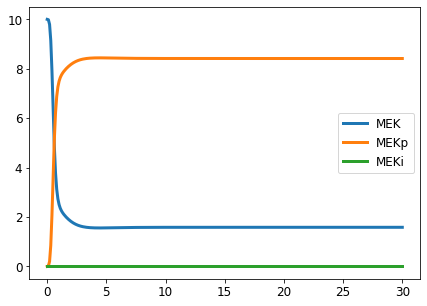

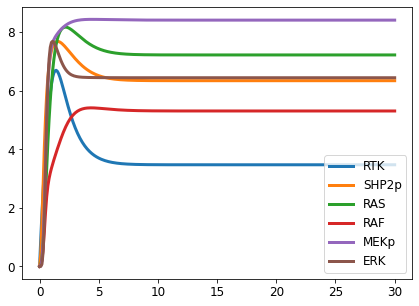

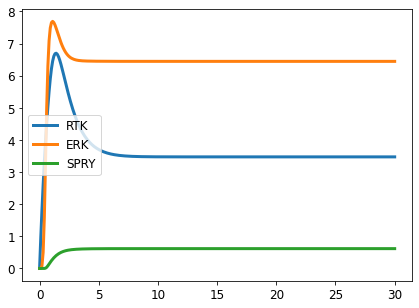

****** MEK inhibitor *********


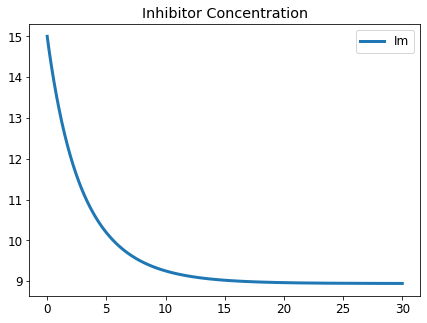

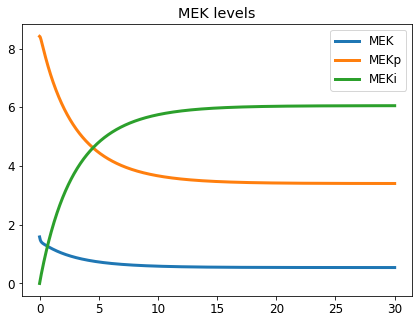

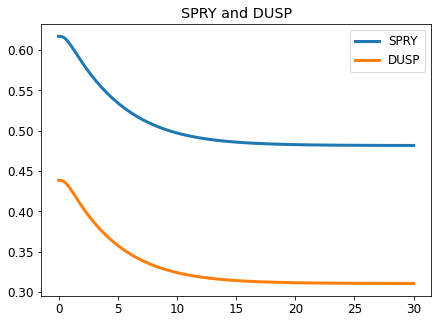

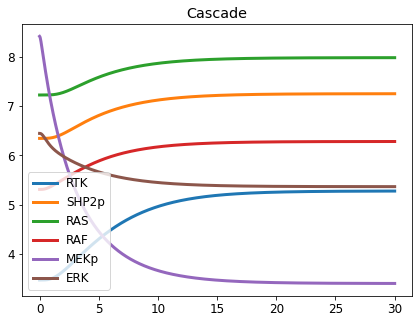

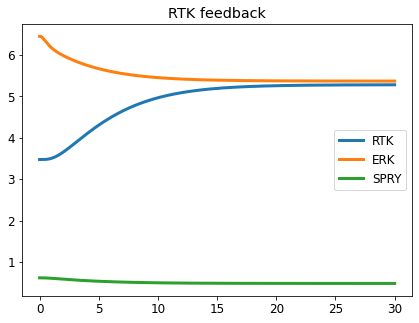

In [42]:
# set time points
t_base = np.linspace(0, 30, 300)

# set initial conditions
y0 = np.zeros(14)
y0[1] = 10 # unphosphorylated SHP2
y0[6] = 10 # unphosphorylated MEK

# set parameters
l = np.ones(3) # non-cascade production
l[0] = 10 # increase production rate of RTK
mu = np.ones(3) # non-cascade clearance
a_hat = np.ones(5)
a_hat[3] = 2 # alpha_mek -> increase level of phosphorylated MEK at SS
a_hat[1] = 0.1 # alpha_RAS
a_hat[2] = 0.2 # alpha_RAF
beta = np.ones(5)*2
beta[2] = 0.5 # beta raf
ct = np.ones(3)*10
ct[0] = 30 # total concentration of RAS
# ct[1] = 30 # total concentration of RAF
k = np.ones(5)
k[4] = 5.5 # increase K for ERKs effect on SPRY
k[0] = 0.5 # make RTK more sensitive to SPRY
# k[1] = 1 # increase K for RAF
k[2] = 0.4
k[1] = 6 # increase K for RAF
k[3] = 7 # K for DUSP
gamma = np.ones(2)*0.1 # complexation rate
epsilon = gamma*0.8 # decomplexation rate
eta = gamma*0.0 # inhibitor clearance rate
sys_args = (l, mu, a_hat, beta, ct, k, gamma, epsilon, eta,)

# integrate system
y_base = odeint(vitro_system, t=t_base, y0=y0, args=sys_args)

# getting steady-state values of base system
base_ss_levels = y_base[-1, :]

# set new initial conditions
y0 = base_ss_levels
y0[13] = 15 # initial Im concentration
t = np.linspace(0, 30, 1000)
y = odeint(vitro_system, t=t, y0=y0, args=sys_args)


# plot base system results
print('***** base system ******')
plot_components(t_base, y_base, "MEK,MEKp,MEKi")
plt.show()

# plot things
plot_cascade(t_base, y_base)
# plt.xlim((0, 30))
plt.show()
plot_rtk_feedback(t_base, y_base)
plt.show()


# plot mek inhibitor system results
print('****** MEK inhibitor *********')
# plot inhibitor concentration
plt.plot(t, y[:, 13], lw=3, label='Im')
plt.title('Inhibitor Concentration')
plt.legend()
plt.show()


# plot MEK concentrations
plot_components(t, y, "MEK,MEKp,MEKi")
plt.title("MEK levels")
plt.show()

plot_components(t, y, "SPRY,DUSP")
plt.title('SPRY and DUSP')
plt.show()

# plot things
plot_cascade(t, y)
plt.title('Cascade')
plt.show()
# plt.xlim((0, 30))
# plt.show()
plot_rtk_feedback(t, y)
plt.title('RTK feedback')
plt.show()

# RAF rate analysis

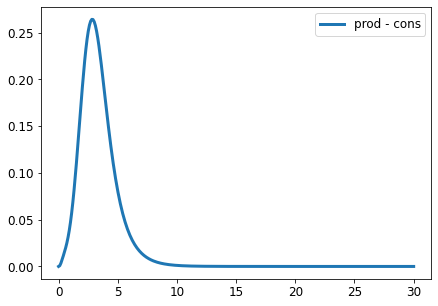

In [17]:
def raf_rate_analysis(y, t, sys_args):
    l, mu, a_hat, beta, ct, k, gamma, epsilon, eta = sys_args

    production = a_hat[2]*ct[1]*y[:, 2]*negative_feedback(y[:, 9], k[1], n=3)*(1 - y[:, 5]/ct[1]) 
    consumption = beta[2]*y[:, 5]

    # plt.plot(t, production, label='production', lw=3)
    # plt.plot(t, consumption, label='consumption', lw=3)
    plt.plot(t, production - consumption, label='prod - cons', lw=3) 
    plt.legend()
    
raf_rate_analysis(y, t, sys_args)
plt.show()

# MEKp rate analysis

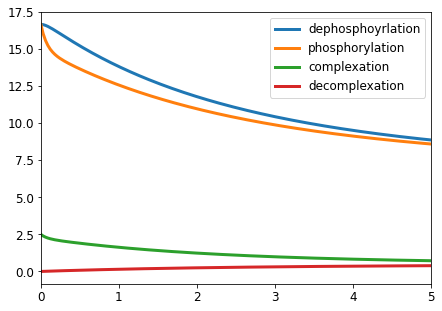

In [37]:
def mek_rate_analysis(y, t, sys_args):
    l, mu, a_hat, beta, ct, k, gamma, epsilon, eta = sys_args

    phos_rate = a_hat[3]*y[:, 5]*y[:, 6]
    dephos_rate = beta[3]*y[:, 7]
    complex_rate = gamma[1]*y[:, 13]*y[:, 6]
    decomplex_rate = epsilon[1]*y[:, 8]
    
    plt.plot(t, dephos_rate, label='dephosphoyrlation', lw=3)
    plt.plot(t, phos_rate, label='phosphorylation', lw=3)
    plt.plot(t, complex_rate, label='complexation', lw=3)
    plt.plot(t, decomplex_rate, label='decomplexation', lw=3)
    plt.legend()

mek_rate_analysis(y, t, sys_args)
plt.xlim((0, 5))
plt.show()

# showing final ERK concentration vs. MEKi dose

In [166]:
np.logspace(-1, 1, 3)

array([ 0.1,  1. , 10. ])

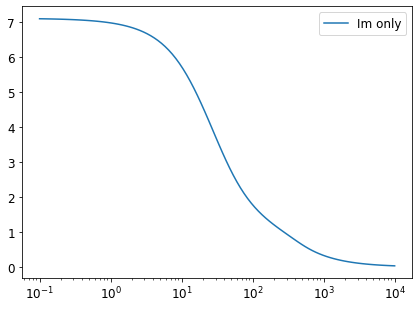

In [33]:
def final_erk_conc(init_im_conc, ss_levels=base_ss_levels, dual=None):
    # set initial conditions
    y0 = base_ss_levels
    if dual is None:
        y0[13] = init_im_conc # initial Im concentration
    else:
        y0[12] = dual
        y0[13] = init_im_conc

    # set time points
    t = np.linspace(0, 30, 200)

    # set parameters
    l = np.ones(3) # non-cascade production
    l[0] = 10 # increase production rate of RTK
    mu = np.ones(3) # non-cascade clearance
    a_hat = np.ones(5)
    a_hat[3] = 10 # alpha_mek -> increase level of phosphorylated MEK at SS
    a_hat[1] = 0.1 # alpha_RAS
    a_hat[2] = 0.2 # alpha_RAF
    beta = np.ones(5)*2
    ct = np.ones(3)*10
    ct[0] = 30 # total concentration of RAS
    ct[1] = 30 # total concentration of RAF
    k = np.ones(5)
    k[4] = 5.5 # increase K for ERKs effect on SPRY
    k[0] = 0.5 # make RTK more sensitive to SPRY
    # k[1] = 1 # increase K for RAF
    k[1] = 25 # increase K for RAF
    gamma = np.ones(2)*0.5 # complexation rate
    epsilon = gamma*0.1 # decomplexation rate
    eta = gamma*0.0 # inhibitor clearance rate
    sys_args = (l, mu, a_hat, beta, ct, k, gamma, epsilon, eta,)

    # integrate system
    y = odeint(vitro_system, t=t, y0=y0, args=sys_args)

    return y[-1, 9]

im = np.logspace(-1, 4, 100)
erk_final = [ final_erk_conc(conc) for conc in im ]
erk_final = np.array(erk_final)

# erk_final_dual = [ final_erk_conc(conc, dual=100) for conc in im ]

plt.plot(im, erk_final, label='Im only')
# plt.plot(im, erk_final_dual, label='Im + Is')
plt.legend()
plt.xscale('log')
plt.show()

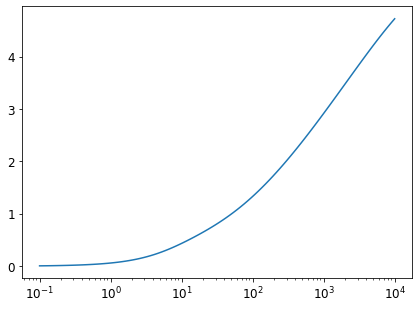

In [190]:
plt.plot(im, erk_final[0] - erk_final)
plt.xscale('log')
plt.show()

# optimization algorithim to find parameters that give a rebound

In [68]:
def unpack_x(x):
    l = x[:3]
    a_hat = x[3:8]
    k = x[8:13]
    gamma = x[13:15]
    epsilon = x[15:17]
    return l, a_hat, k, gamma, epsilon

def rebound_error(x):
    l, a_hat, k, gamma, epsilon = unpack_x(x)

    mu = np.ones(3) # non-cascade clearance
    beta = np.ones(5)
    ct = np.ones(3)*10
    eta = np.zeros(2) # complexation rate
    sys_args = (l, mu, a_hat, beta, ct, k, gamma, epsilon, eta,)

    # simulate with init concentrations of 0 to get SS
    t = np.linspace(0, 30, 50)
    y0 = np.zeros(14)
    y0[1] = 10 # unphosphorylated SHP2
    y0[6] = 10 # unphosphorylated MEK
    y_base = odeint(vitro_system, y0=y0, t=t, args=sys_args)

    # simulate with SS values to start but add MEK inhibitor
    y0 = y_base[-1, :]
    y0[13] = 20 # initial Im concentration
    y = odeint(vitro_system, y0=y0, t=t, args=sys_args)

    # get difference between final and intial ERK concentration
    erk_init = y0[9]
    erk_final = y[-1, 9]

    # get diff between erk_init and min
    erk_min = min(y[:, 9])
    erk_change = np.abs(erk_init - erk_min)
    if erk_change > 1:
        penalty = 0
    else:
        penalty = 100*(1 - erk_change)
    return 100*(erk_init - erk_final)**2 + penalty

# set inital guess for x
l = np.ones(3) 
a_hat = np.ones(5)
a_hat[1:] = 0.1
k = np.ones(5)*5
k[0] = 0.5
gamma = np.ones(2) # decomplexation rate
epsilon = np.ones(2) # inhibitor clearance rate
x0 = np.concatenate([l, a_hat, k, gamma, epsilon])

bounds = [ (1e-2, 100) for _ in x0 ]

result = minimize(rebound_error, x0=x0, bounds=bounds)

result

      fun: 17.934249891866997
 hess_inv: <17x17 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 295.94842562,  562.00049167,  453.61594223,  247.60708624,
        454.52998296,  -11.88635366,  190.09172627,  -16.84821466,
       3396.1317609 , 1471.42317577,  330.91760182,  381.55135745,
        244.3882402 ,    0.        ,  378.19133422,    0.        ,
       1224.67094484])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 5112
      nit: 21
     njev: 284
   status: 2
  success: False
        x: array([9.75689826, 0.99858361, 1.07256599, 9.76421356, 0.09939969,
       6.87077442, 5.40772497, 3.39921358, 0.01018856, 0.03918064,
       5.01119771, 4.99142096, 4.67632152, 1.        , 9.80603039,
       1.        , 8.32445302])

In [17]:
gamma, epsilon, eta

(array([1.        , 0.78978457]),
 array([1.        , 0.85634815]),
 array([0., 0.]))

In [74]:
l

array([9.75689826, 0.99858361, 1.07256599])

*******base system********


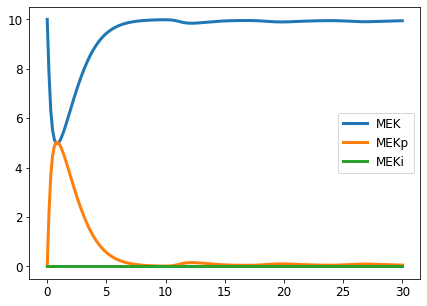

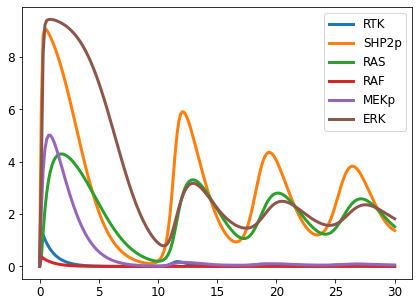

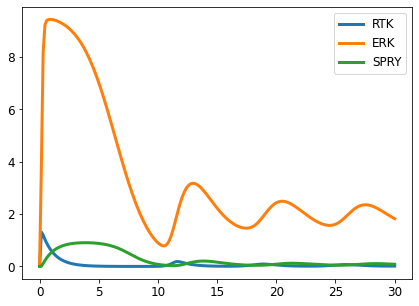

***** inhibitor addition ********


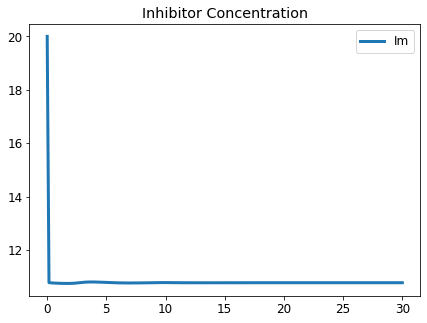

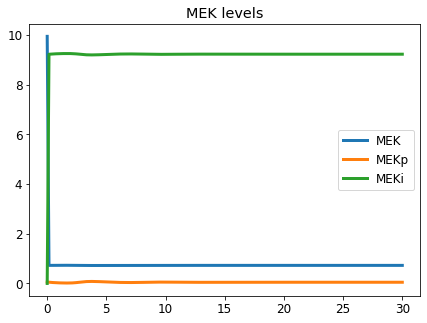

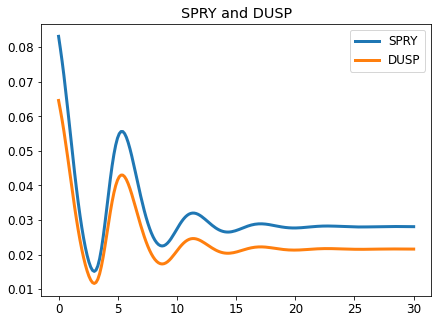

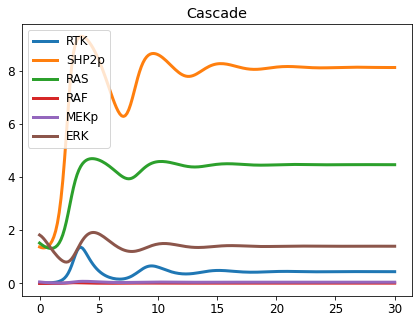

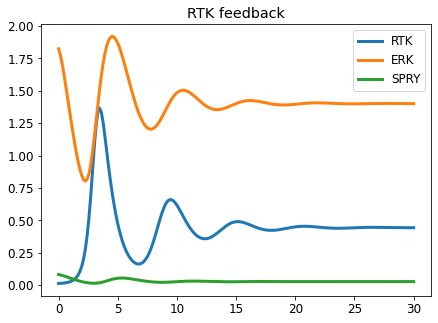

In [69]:
# show results

l, a_hat, k, gamma, epsilon = unpack_x(result.x)

mu = np.ones(3) # non-cascade clearance
beta = np.ones(5)
ct = np.ones(3)*10
eta = np.zeros(2) # complexation rate
sys_args = (l, mu, a_hat, beta, ct, k, gamma, epsilon, eta,)

t = np.linspace(0, 30, 200)
y0 = np.zeros(14)
y0[1] = 10 # unphosphorylated SHP2
y0[6] = 10 # unphosphorylated MEK
y_base = odeint(vitro_system, y0=y0, t=t, args=sys_args)


y0 = y_base[-1, :]
y0[13] = 20 # initial Im concentration
y = odeint(vitro_system, y0=y0, t=t, args=sys_args)

print('*******base system********')

plot_components(t, y_base, "MEK,MEKp,MEKi")
plt.show()

# plot things
plot_cascade(t, y_base)
# plt.xlim((0, 30))
plt.show()
plot_rtk_feedback(t, y_base)
plt.show()


print('***** inhibitor addition ********')


# plot inhibitor concentration
plt.plot(t, y[:, 13], lw=3, label='Im')
plt.title('Inhibitor Concentration')
plt.legend()
plt.show()


# plot MEK concentrations
plot_components(t, y, "MEK,MEKp,MEKi")
plt.title("MEK levels")
plt.show()

plot_components(t, y, "SPRY,DUSP")
plt.title('SPRY and DUSP')
plt.show()

# plot things
plot_cascade(t, y)
plt.title('Cascade')
plt.show()
# plt.xlim((0, 30))
# plt.show()
plot_rtk_feedback(t, y)
plt.title('RTK feedback')
plt.show()

# modeling dual MEKi and SHP2i addition

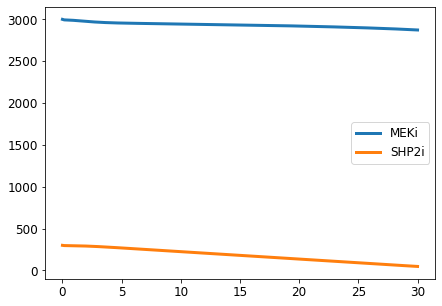

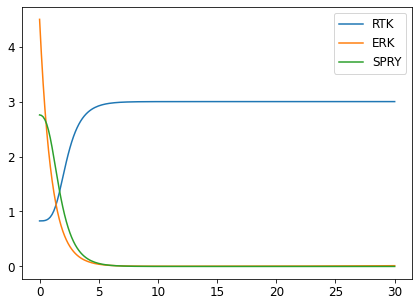

In [24]:
# getting steady-state values of base system
base_ss_levels = y_base[-1, :]

# set initial conditions
y0 = base_ss_levels
y0[9] = 3000
y0[8] = 300

# set time points
t = np.linspace(0, 30, 200)

# set parameters
alpha = np.ones(y0.shape[0] - 2)*3
beta = np.ones(y0.shape[0] - 2)
k = np.ones(5)*2
gamma = np.ones(2)*0.5
sys_args = (alpha, beta, k, gamma,)

# integrate system
y = odeint(system_w_inhibitors, t=t, y0=y0, args=sys_args)


# plot inhibitor concentration
plt.plot(t, y[:, 9], lw=3, label='MEKi')
plt.plot(t, y[:, 8], lw=3, label='SHP2i')
plt.legend()
plt.show()

# plot things
# plot_cascade(t, y)
# plt.xlim((0, 30))
# plt.show()
plot_rtk_feedback(t, y)
plt.show()